Imports

In [1]:
import os
import scipy as sp
import numpy as np
import time
from matplotlib import pyplot as plt
from stereoid.oceans.forward_models import SAR_spectra as SAR_model
from stereoid.instrument import ObsGeo
import drama.geo as sargeo
from stereoid.oceans.waves import wave_spectra

# output folder
outpath='/Users/marcelmac/Documents/Papers/BistaticSARtransform/'
# Run ID
mode = "IWS"
run_id='ocean_' + mode

# stereoid path
path='/Users/marcelmac/Data/Harmony'
pardir=path + '/PAR/'
parfile=pardir + 'Hrmny_2021_1.cfg'
main_dir=path + ''

Set some geometry

In [2]:
# Incident angle
incm = np.deg2rad(35)
along_track_separation=350E3 # should be consistent with the PAR file
swth_bst = sargeo.SingleSwathBistatic(par_file=parfile, dau=along_track_separation)
# Observation geometry calculated from orbit
obsgeo = ObsGeo.from_swath_geo(incm, swth_bst, ascending=True)
# receiver/transmitter range
Ix=np.argmin(np.absolute(incm-np.degrees(swth_bst.master_inc[0,:])))
Rt=swth_bst.master_range[0,Ix]
Rr=swth_bst.slave_range[0,Ix]
# angles
bist_ang=obsgeo.bist_ang
inc_m=obsgeo.inc_m
inc_b=obsgeo.inc_b
# rotation angle for MACS and cut-off
alpha_rot=np.arctan(np.sin(bist_ang)*np.sin(inc_b)/(np.sin(inc_m)+ np.cos(bist_ang)*np.sin(inc_b)))

Spectrum settings

In [3]:
# wave numbers in a Cartesian grids (kx=cross,ky=along)
g = 9.81
scene_size = 5000  # maximum wavelength (size of image)
dx = 5
dy = 5
Nx=int(scene_size/dx)
Ny=int(scene_size/dy)
kx = np.ones( (1, Nx) )
ky = np.ones( (Ny, 1) )
dk = 2 * np.pi / scene_size  # fundamental frequency
kx[ 0, 0:int( Nx / 2 ) ] = dk * np.arange( 0, Nx / 2 )
kx[ 0, int( Nx / 2 ): ] = dk * np.arange( -Nx / 2, 0 )
kx = np.dot( np.ones( (Ny, 1) ), kx )
ky[ 0:int( Ny / 2 ), 0 ] = dk * np.arange( 0, Ny / 2 )
ky[ int( Ny / 2 ):, 0 ] = dk * np.arange( -Ny / 2, 0 )
ky = np.dot( ky, np.ones( (1, Nx) ) )
k = np.sqrt( kx ** 2 + ky ** 2 )
omega = np.sqrt( g * k )  # angular velocity
phi = np.arctan2( ky, kx )  # 0 is cross-track direction waves, 90 along-track
shp=k.shape

Wave spectrum

3.1432944280210577


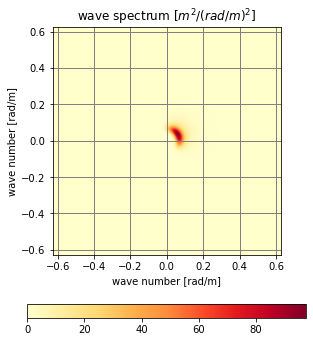

In [4]:
S=np.zeros(k.shape)
###### let's do this with Elfouhaily
wind_U=20 # wind speed
wind_fetch=100E3 # fetch
wind_dir=30 # wind direction

# wave-number spectrum
Sp=wave_spectra.elfouhaily(k,wind_U,wind_fetch)
Sp[0,0]=0

# directional distribution
dphi = (np.deg2rad(wind_dir)-phi+np.pi) % (2 * np.pi) - np.pi # including unwrapping
D=wave_spectra.elfouhaily_spread(k, dphi, wind_U, wind_fetch)
D[0,0]=0

# Cartesian spectrum
S=Sp*D/k
S[0,0]=0
print(np.sqrt(np.sum(S*dk*dk))*4)

plt.figure(figsize=(5,6))
plt.imshow(np.fft.fftshift(S), origin='lower',extent=(np.min(kx),np.max(kx),np.min(ky),np.max(ky)),cmap='YlOrRd')
plt.grid(color='grey', linestyle='-', linewidth=1)
plt.xlabel('wave number [rad/m]')
plt.ylabel('wave number [rad/m]')
plt.colorbar(orientation='horizontal')
plt.title('wave spectrum [$m^2/(rad/m)^2$]')

# scaling (2*pi-scaling inside of the correlation functions)
S=S*Nx*Ny*dk*dk
wn_grid={"S": S,"k_x": kx,"k_y": ky}

Compute variances

In [5]:
# get cross-correlations
MTF='Kirchhoff'
T_I = SAR_model.transfer_func_RAR_bist( kx, ky, inc_m, inc_m, np.radians(0.0001), mtf = MTF )
II, yy, xx, Iy, yI, Ix, xI, xy, yx = SAR_model.corr_func_bist( wn_grid, T_I, inc_m, inc_m, np.radians(0.0001), Rt, Rt )
Pm=np.exp(-ky**2*yy[0,0]-kx**2*xx[0,0]-kx*ky*(xy[0,0]+yx[0,0]))
T_I = SAR_model.transfer_func_RAR_bist( kx, ky, inc_m, inc_b, bist_ang, mtf = MTF )
II, yy, xx, Iy, yI, Ix, xI, xy, yx = SAR_model.corr_func_bist( wn_grid, T_I, inc_m, inc_b, bist_ang, Rt, Rr )
Pf=np.exp(-ky**2*yy[0,0]-kx**2*xx[0,0]-kx*ky*(xy[0,0]+yx[0,0]))
T_I = SAR_model.transfer_func_RAR_bist( kx, ky, inc_m, inc_b, bist_ang, mtf = MTF )
II, yy, xx, Iy, yI, Ix, xI, xy, yx = SAR_model.corr_func_bist( wn_grid, T_I, inc_m, inc_b, -bist_ang, Rt, Rr )
Pb=np.exp(-ky**2*yy[0,0]-kx**2*xx[0,0]-kx*ky*(xy[0,0]+yx[0,0]))

Plots

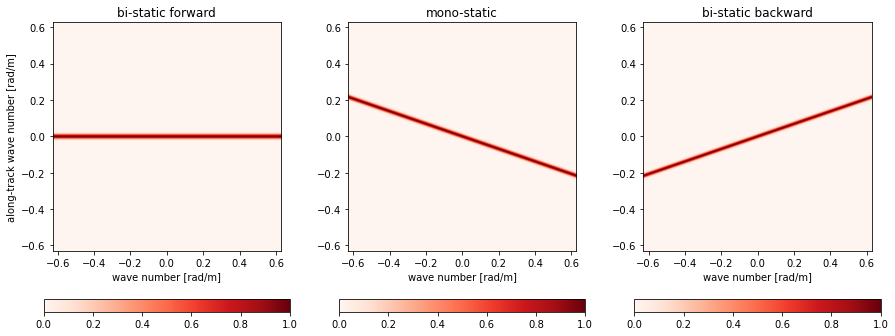

In [6]:
plt.figure(figsize=(15,6))
# bi-static case (forward)
plt.subplot(1,3,1)
plt.imshow(np.fft.fftshift(Pm),extent=(np.min(kx),np.max(kx),np.min(ky),np.max(ky)),cmap='Reds', origin='lower')
plt.title('bi-static forward')
plt.xlabel('wave number [rad/m]')
plt.ylabel('along-track wave number [rad/m]')
plt.colorbar(orientation='horizontal')

# mono-static case
plt.subplot(1,3,2)
plt.imshow(np.fft.fftshift(Pf),extent=(np.min(kx),np.max(kx),np.min(ky),np.max(ky)),cmap='Reds', origin='lower')
plt.title('mono-static')
plt.xlabel('wave number [rad/m]')
plt.colorbar(orientation='horizontal')

# bi-static case (forward)
plt.subplot(1,3,3)
plt.imshow(np.fft.fftshift(Pb),extent=(np.min(kx),np.max(kx),np.min(ky),np.max(ky)),cmap='Reds', origin='lower')
plt.title('bi-static backward')
plt.xlabel('wave number [rad/m]')
plt.colorbar(orientation='horizontal')

Spectral coverage

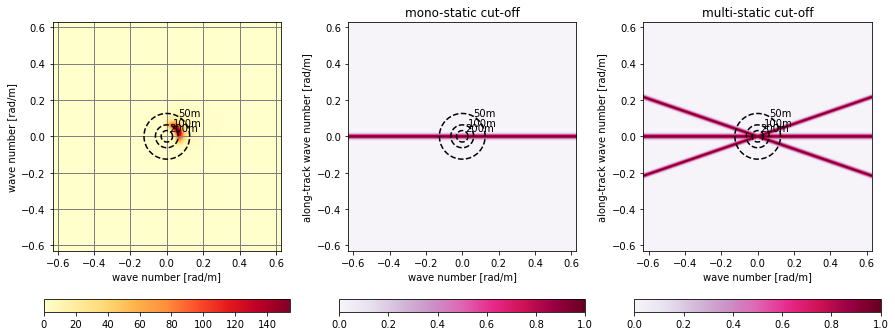

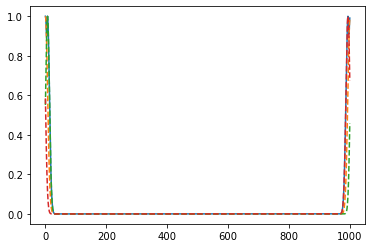

In [7]:
# compute 'coverage'
P=np.max((Pm,Pf,Pb), 0)

# wavelength circles
k100=2*np.pi/100;
k200=2*np.pi/200;
k50=2*np.pi/50;
ph=np.linspace(0,2*np.pi,61)
kx50=np.cos(ph)*k50
ky50=np.sin(ph)*k50
kx100=np.cos(ph)*k100
ky100=np.sin(ph)*k100
kx200=np.cos(ph)*k200
ky200=np.sin(ph)*k200


# plots
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.imshow(np.fft.fftshift(S), origin='lower',extent=(np.min(kx),np.max(kx),np.min(ky),np.max(ky)),cmap='YlOrRd')
plt.grid(color='grey', linestyle='-', linewidth=1)
plt.xlabel('wave number [rad/m]')
plt.ylabel('wave number [rad/m]')
plt.colorbar(orientation='horizontal')
#plt.title('wave spectrum [$m^2/(rad/m)^2$]')
plt.plot(kx50,ky50,'k--')
plt.plot(kx100,ky100,'k--')
plt.plot(kx200,ky200,'k--')
plt.text(kx50[10],ky50[10],'50m',color='k')
plt.text(kx100[10],ky100[10],'100m',color='k')
plt.text(kx200[10],ky200[10],'200m',color='k')
plt.subplot(1,3,2)
plt.imshow(np.fft.fftshift(Pm),extent=(np.min(kx),np.max(kx),np.min(ky),np.max(ky)),cmap='PuRd', origin='lower')
plt.title('mono-static cut-off')
plt.xlabel('wave number [rad/m]')
plt.ylabel('along-track wave number [rad/m]')
plt.colorbar(orientation='horizontal')
plt.plot(kx50,ky50,'k--')
plt.plot(kx100,ky100,'k--')
plt.plot(kx200,ky200,'k--')
plt.text(kx50[10],ky50[10],'50m',color='k')
plt.text(kx100[10],ky100[10],'100m',color='k')
plt.text(kx200[10],ky200[10],'200m',color='k')
plt.subplot(1,3,3)
plt.imshow(np.fft.fftshift(P),extent=(np.min(kx),np.max(kx),np.min(ky),np.max(ky)),cmap='PuRd', origin='lower')
plt.title('multi-static cut-off')
plt.xlabel('wave number [rad/m]')
plt.ylabel('along-track wave number [rad/m]')
plt.colorbar(orientation='horizontal')
plt.plot(kx50,ky50,'k--')
plt.plot(kx100,ky100,'k--')
plt.plot(kx200,ky200,'k--')
plt.text(kx50[10],ky50[10],'50m',color='k')
plt.text(kx100[10],ky100[10],'100m',color='k')
plt.text(kx200[10],ky200[10],'200m',color='k')

plt.figure()
plt.plot(P[:,20])
plt.plot(Pm[:,20],'--')
plt.plot(Pb[:,20],'--')
plt.plot(Pf[:,20],'--')

Fractional coverage vs wave height

In [ ]:
Plim=0.5
winds=range(5,36)
Hs=np.zeros(len(winds)) # significant wave height

# fractions
Fs=np.zeros(len(winds)) # fraction of total with single satellite
Fm=np.zeros(len(winds)) # fraction of total with multiple satellites (Harmony)
Fs_200=np.zeros(len(winds)) # fraction above 150 m, below 150 m with single satellite
Fm_200=np.zeros(len(winds)) # fraction above 150 m, below 150 m with multiple satellites (Harmony)
Fs_100200=np.zeros(len(winds)) # fraction above 100, below 150 m with single satellite
Fm_100200=np.zeros(len(winds)) # fraction above 100, below 150 m with multiple satellites (Harmony)
Fs_100=np.zeros(len(winds)) # fraction below 100 m, but greater than grid resolution with single satellite
Fm_100=np.zeros(len(winds)) # fraction below 100 m, but greater than grid resolution with multiple satellites (Harmony)

# get indices of wavelengths groups
I_200=np.where(k < 2*np.pi/200)
I_100200=np.where(np.logical_and(k > 2*np.pi/200,k < 2*np.pi/100))
I_100=np.where(k > 2*np.pi/100)

kk=0
for i in winds:
    wind_U=i # wind speed

    # we make a combined spectrum of wind waves 
    S=np.zeros(k.shape)
    ###### let's do this with Elfouhaily
    wind_fetch=500E3 # fetch
    wind_dir=30 # wind direction

    # wave-number spectrum
    Sp=wave_spectra.elfouhaily(k,wind_U,wind_fetch)
    Sp[0,0]=0

    # directional distribution
    dphi = (np.deg2rad(wind_dir)-phi+np.pi) % (2 * np.pi) - np.pi # including unwrapping
    D=wave_spectra.elfouhaily_spread(k, dphi, wind_U, wind_fetch)
    D[0,0]=0

    # Cartesian spectrum
    S=Sp*D/k
    S[0,0]=0
    Hs[kk]=np.sqrt(np.sum(S*dk*dk))*4 # wave height
    
    # scaling
    S=S*Nx*Ny*dk*dk
    wn_grid={"S": S,"k_x": kx,"k_y": ky}

    # get cross-correlations
    T_I = SAR_model.transfer_func_RAR_bist( kx, ky, inc_m, inc_m, np.radians(0.0001), mtf = MTF )
    II, yy, xx, Iy, yI, Ix, xI, xy, yx = SAR_model.corr_func_bist( wn_grid, T_I, inc_m, inc_m, np.radians(0.0001), Rt, Rt )
    Pm=np.exp(-ky**2*yy[0,0]-kx**2*xx[0,0]-kx*ky*(xy[0,0]+yx[0,0]))
    T_I = SAR_model.transfer_func_RAR_bist( kx, ky, inc_m, inc_b, bist_ang, mtf = MTF )
    II, yy, xx, Iy, yI, Ix, xI, xy, yx = SAR_model.corr_func_bist( wn_grid, T_I, inc_m, inc_b, bist_ang, Rt, Rr )
    Pf=np.exp(-ky**2*yy[0,0]-kx**2*xx[0,0]-kx*ky*(xy[0,0]+yx[0,0]))
    T_I = SAR_model.transfer_func_RAR_bist( kx, ky, inc_m, inc_b, bist_ang, mtf = MTF )
    II, yy, xx, Iy, yI, Ix, xI, xy, yx = SAR_model.corr_func_bist( wn_grid, T_I, inc_m, inc_b, -bist_ang, Rt, Rr )
    Pb=np.exp(-ky**2*yy[0,0]-kx**2*xx[0,0]-kx*ky*(xy[0,0]+yx[0,0]))

    # take maximum
    P=np.max((Pm,Pf,Pb), 0)
    
    # spectrum visibility
    Fs[kk]=np.sum(Pm>Plim)/len(Pm[0,:])/len(Pm[:,0]) # mono-static only (watch out, confusing Fs refers to single, Pm is mono)
    Fm[kk]=np.sum(P>Plim)/len(P[0,:])/len(P[:,0]) # multi-static (watch out, confusing Fm refers to multiple, Pm is mono)
    
    # wavelength regime visibility
    Pm_200=P[I_200] # multistatic P split
    Pm_100200=P[I_100200]
    Pm_100=P[I_100]
    Ps_200=Pm[I_200] # single satelite P split
    Ps_100200=Pm[I_100200]
    Ps_100=Pm[I_100]
    Fs_100[kk]=np.sum(Ps_100>Plim)/len(Ps_100) # mono-static only (single satellite)
    Fm_100[kk]=np.sum(Pm_100>Plim)/len(Pm_100) # multi-static
    Fs_100200[kk]=np.sum(Ps_100200>Plim)/len(Ps_100200) # mono-static only (single satellite)
    Fm_100200[kk]=np.sum(Pm_100200>Plim)/len(Pm_100200) # multi-static
    Fs_200[kk]=np.sum(Ps_200>Plim)/len(Ps_200) # mono-static only (single satellite)
    Fm_200[kk]=np.sum(Pm_200>Plim)/len(Pm_200) # multi-static
    
    kk=kk+1

Plots

In [ ]:
plt.figure(figsize=(10,5))    
#plt.subplot(2,1,1)
#plt.plot(Hs,Fs,linewidth=2,label='Sentinel-1 only')
#plt.plot(Hs,Fm,linewidth=2,label='Harmony')
#plt.ylim(0,1)
#plt.grid('on')
#plt.xlabel('significant wave height [m]')
#plt.ylabel('relative fraction [-]')
#plt.title('wave numbers with <50% signal loss')
#plt.legend()
#plt.subplot(2,1,2)
plt.plot(Hs,Fs_100,linewidth=2,linestyle='--',color='purple',label='<100 m Sentinel-1')
plt.plot(Hs,Fm_100,linewidth=2,color='purple',label='<100 m Harmony')
plt.plot(Hs,Fs_100200,linewidth=2,linestyle='--',color='orange',label='100-200 m Sentinel-1')
plt.plot(Hs,Fm_100200,linewidth=2,color='orange',label='100-200 m Harmony')
plt.plot(Hs,Fs_200,linewidth=2,linestyle='--',color='lightblue',label='>200 m Sentinel-1')
plt.plot(Hs,Fm_200,linewidth=2,color='lightblue',label='>200 m Harmony')
plt.ylim(0,1)
plt.grid('on')
plt.xlabel('significant wave height [m]')
plt.ylabel('relative fraction [-]')
plt.title('spectrum inside 3 dB cut-off')
plt.legend()
plt.savefig(outpath + 'SpectralCoverageVSWaveHeight.png',dpi=300)